# TFM

data: https://drive.google.com/drive/folders/1fx_j6gmiATvhEaBtUwEPuCOl8peJ2zDM

## 1. Simple k-NN implementation

In [120]:
import math
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import time

### Euclidean distance

In [64]:
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

#### Time comparison

In [98]:
row0 = df_tstrss_DSI1[0]
start = time.time()
for row in df_trnrss_DSI1:
    euclidean_distance(row0, row)
end = time.time()
print(end - start)

0.07283163070678711


In [100]:
a = np.array(df_tstrss_DSI1[0])
b = np.array(df_trnrss_DSI1)
start = time.time()
for row in b:
    np.linalg.norm(a-b)
end = time.time()
print(end - start)

1.3762853145599365


In [102]:
start = time.time()
for row in df_trnrss_DSI1:
    np.sqrt(np.sum(np.square(a-b)))
end = time.time()
print(end - start)

0.6153531074523926


In [104]:
from scipy.spatial import distance
start = time.time()
for row in df_trnrss_DSI1:
    distance.euclidean(row0, row)
end = time.time()
print(end - start)

0.058870792388916016


In [121]:
# WINNER
start = time.time()
for row in df_trnrss_DSI1:
    math.dist(row0, row)
end = time.time()
print(end - start)

0.005949497222900391


### Get k-nearest neighbors

In [123]:
# Locate the most similar neighbors and return list of indexes
def get_neighbors(train, test_row, k):
    distances = list()
    for idx, train_row in enumerate(train):
        dist = math.dist(test_row, train_row)
        distances.append((idx, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors

#### Time comparison

In [128]:
start = time.time()
neighbors = get_neighbors(df_trnrss_DSI1, row0, 3)
end = time.time()
print(end - start)

0.00697636604309082


### Data from csv

In [58]:
def load_Data(name):
    # TRAIN data
    # load fingerprints
    df_trnrss_DSI1 = pd.read_csv('data/'+ name + '_trnrss.csv', header=None)
    df_trnrss_DSI1 = df_trnrss_DSI1.values.tolist()
    # load coordinates
    df_trncrd_DSI1 = pd.read_csv('data/' + name + '_trncrd.csv', header=None)

    # for now, drop columns of 'floor' and 'building', keep x,y,z
    df_trncrd_DSI1.drop(df_trncrd_DSI1.columns[[3,4]], axis=1, inplace=True)
    df_trncrd_DSI1 = df_trncrd_DSI1.values.tolist()

    # TEST data
    # load fingerprints
    df_tstrss_DSI1 = pd.read_csv('data/' + name + '_tstrss.csv', header=None)
    df_tstrss_DSI1 = df_tstrss_DSI1.values.tolist()
    # load coordinates
    df_tstcrd_DSI1 = pd.read_csv('data/' + name + '_tstcrd.csv', header=None)

    # for now, drop columns of 'floor' and 'building', keep x,y,z
    df_tstcrd_DSI1.drop(df_tstcrd_DSI1.columns[[3,4]], axis=1, inplace=True)
    df_tstcrd_DSI1 = df_tstcrd_DSI1.values.tolist()
    
    return(df_trnrss_DSI1, df_trncrd_DSI1, df_tstrss_DSI1, df_tstcrd_DSI1)

In [60]:
df_trnrss_DSI1, df_trncrd_DSI1, df_tstrss_DSI1, df_tstcrd_DSI1 = load_Data("DSI1")
df_trnrss_DSI2, df_trncrd_DSI2, df_tstrss_DSI2, df_tstcrd_DSI2 = load_Data("DSI2")
df_trnrss_LIB1, df_trncrd_LIB1, df_tstrss_LIB1, df_tstcrd_LIB1 = load_Data("LIB1")
df_trnrss_LIB2, df_trncrd_LIB2, df_tstrss_LIB2, df_tstcrd_LIB2 = load_Data("LIB2")
df_trnrss_MAN2, df_trncrd_MAN2, df_tstrss_MAN2, df_tstcrd_MAN2 = load_Data("MAN2")
df_trnrss_SIM001, df_trncrd_SIM001, df_tstrss_SIM001, df_tstcrd_SIM001 = load_Data("SIM001")

### Algorithm

In [122]:
# calculate knn of fingerprints
def knn(k, tstrss, trnrss):
    all_neighbors = []

    # iterate test data and find id of k nearest neighbors from trnrss
    for i in tstrss:
        all_neighbors.append(get_neighbors(trnrss, i, k))
        
    return(all_neighbors)

# predict position of neighbors 
def predict_position(all_neighbors, trncrd):
    predicted_pos = []
    
    # iterate all neighbors to predict position. Find k indexes in trncrd and calculate mean value.
    for knn in all_neighbors:    
        x, y, z = 0, 0, 0
        for i in knn:
            x += trncrd[i][0]
            y += trncrd[i][1]
            z += trncrd[i][2]
        predicted_pos.append([x/k, y/k, round(z/k, 1)]) # mean of the error
        
    return(predicted_pos)

# error calculation: euclidean distance between predictions and tstcrd
def calculate_error(predicted_pos, tstcrd):
    error_distances = []
    for i, val in enumerate(predicted_pos):
        error_distances.append(math.dist(predicted_pos[i], tstcrd[i]))
    
    return(error_distances)

def error_dist_knn(k, tstrss, trnrss, tstcrd, trncrd):
    neighbors = knn(k, tstrss, trnrss)
    predicted_positions = predict_position(neighbors, trncrd)
    return(calculate_error(predicted_positions, tstcrd))

### Calculations

In [132]:
start = time.time()
k=1
k1_DSI1 = error_dist_knn(k, df_tstrss_DSI1, df_trnrss_DSI1, df_tstcrd_DSI1, df_trncrd_DSI1)
k1_DSI2 = error_dist_knn(k, df_tstrss_DSI2, df_trnrss_DSI2, df_tstcrd_DSI2, df_trncrd_DSI2)
k1_LIB1 = error_dist_knn(k, df_tstrss_LIB1, df_trnrss_LIB1, df_tstcrd_LIB1, df_trncrd_LIB1)
k1_LIB2 = error_dist_knn(k, df_tstrss_LIB2, df_trnrss_LIB2, df_tstcrd_LIB2, df_trncrd_LIB2)
k1_MAN2 = error_dist_knn(k, df_tstrss_MAN2, df_trnrss_MAN2, df_tstcrd_MAN2, df_trncrd_MAN2)
k1_SIM001 = error_dist_knn(k, df_tstrss_SIM001, df_trnrss_SIM001, df_tstcrd_SIM001, df_trncrd_SIM001)

k=5
k5_DSI1 = error_dist_knn(k, df_tstrss_DSI1, df_trnrss_DSI1, df_tstcrd_DSI1, df_trncrd_DSI1)
k5_DSI2 = error_dist_knn(k, df_tstrss_DSI2, df_trnrss_DSI2, df_tstcrd_DSI2, df_trncrd_DSI2)
k5_LIB1 = error_dist_knn(k, df_tstrss_LIB1, df_trnrss_LIB1, df_tstcrd_LIB1, df_trncrd_LIB1)
k5_LIB2 = error_dist_knn(k, df_tstrss_LIB2, df_trnrss_LIB2, df_tstcrd_LIB2, df_trncrd_LIB2)
k5_MAN2 = error_dist_knn(k, df_tstrss_MAN2, df_trnrss_MAN2, df_tstcrd_MAN2, df_trncrd_MAN2)
k5_SIM001 = error_dist_knn(k, df_tstrss_SIM001, df_trnrss_SIM001, df_tstcrd_SIM001, df_trncrd_SIM001)

k=11
k11_DSI1 = error_dist_knn(k, df_tstrss_DSI1, df_trnrss_DSI1, df_tstcrd_DSI1, df_trncrd_DSI1)
k11_DSI2 = error_dist_knn(k, df_tstrss_DSI2, df_trnrss_DSI2, df_tstcrd_DSI2, df_trncrd_DSI2)
k11_LIB1 = error_dist_knn(k, df_tstrss_LIB1, df_trnrss_LIB1, df_tstcrd_LIB1, df_trncrd_LIB1)
k11_LIB2 = error_dist_knn(k, df_tstrss_LIB2, df_trnrss_LIB2, df_tstcrd_LIB2, df_trncrd_LIB2)
k11_MAN2 = error_dist_knn(k, df_tstrss_MAN2, df_trnrss_MAN2, df_tstcrd_MAN2, df_trncrd_MAN2)
k11_SIM001 = error_dist_knn(k, df_tstrss_SIM001, df_trnrss_SIM001, df_tstcrd_SIM001, df_trncrd_SIM001)
end = time.time()
print(end - start)

80.15557169914246


In [131]:
start = time.time()
k=1
k1_DSI1 = error_dist_knn(k, df_tstrss_DSI1, df_trnrss_DSI1, df_tstcrd_DSI1, df_trncrd_DSI1)
k=5
k5_DSI1 = error_dist_knn(k, df_tstrss_DSI1, df_trnrss_DSI1, df_tstcrd_DSI1, df_trncrd_DSI1)
k=11
k11_DSI1 = error_dist_knn(k, df_tstrss_DSI1, df_trnrss_DSI1, df_tstcrd_DSI1, df_trncrd_DSI1)
end = time.time()
print(end - start)

5.44112491607666


### ECDF

In [13]:
#ECDF function to generate x and y axis data
def ecdf(xdata):
    xdataecdf = np.sort(xdata)
    ydataecdf = np.arange(1, len(xdata) + 1) / len(xdata)
    return xdataecdf, ydataecdf

def plot_ecdf(data1, data2, data3, title, figure):
    #Get the x and y data for ecdf plot from ecdf method
    x1,y1 = ecdf(data1)
    x5,y5 = ecdf(data2)
    x11,y11 = ecdf(data3)

    #Plot the data using matplotlib
    plt.figure(figure)
    plt.plot(x1, y1, marker = '.', linestyle = 'none', markersize = 3)
    plt.plot(x5, y5, marker = '.', linestyle = 'none', markersize = 3)
    plt.plot(x11, y11, marker = '.', linestyle = 'none', markersize = 3)
    plt.legend(("k=1", "k=5", "k=11"))
    plt.title(title)
    plt.xlabel('Error distance')
    plt.ylabel('Error probability')
    plt.margins(0.1)

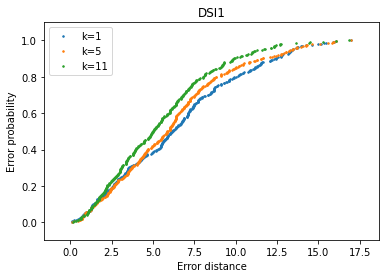

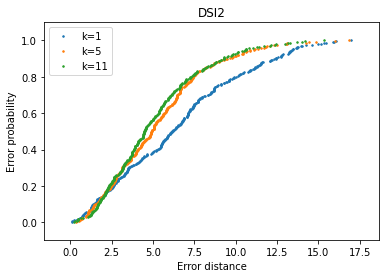

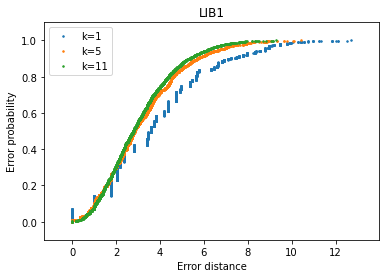

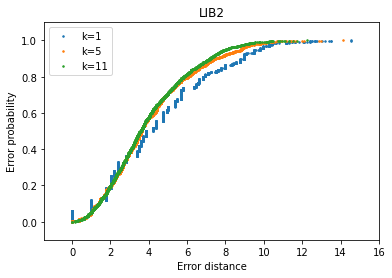

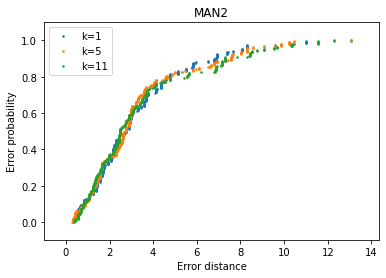

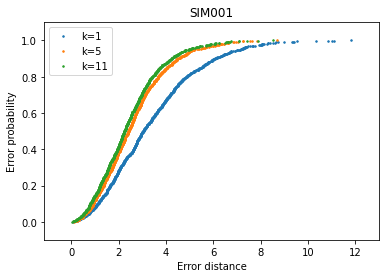

In [133]:
plot_ecdf(k1_DSI1, k5_DSI1, k11_DSI1, "DSI1", 1)
plot_ecdf(k1_DSI2, k5_DSI2, k11_DSI2, "DSI2", 2)
plot_ecdf(k1_LIB1, k5_LIB1, k11_LIB1, "LIB1", 3)
plot_ecdf(k1_LIB2, k5_LIB2, k11_LIB2, "LIB2", 4)
plot_ecdf(k1_MAN2, k5_MAN2, k11_MAN2, "MAN2", 5)
plot_ecdf(k1_SIM001, k5_SIM001, k11_SIM001, "SIM001", 6)

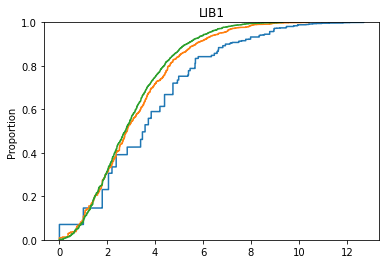

In [31]:
#Import seaborn library and generate ecdf plot here
sns.ecdfplot(x = k1_LIB1).set_title('LIB1');
sns.ecdfplot(x = k5_LIB1);
sns.ecdfplot(x = k11_LIB1);